In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm
from autograd import grad
import holoviews as hv
hv.notebook_extension()

## Simple Hamiltonian Monte Carlo implementation with autograd

Using the `python` / `numpy` automatic differentiation package [`autograd`](https://github.com/HIPS/autograd) we can produce a relatively black-box HMC implementation that can sample from arbitrary real-valued target densities defined by a `python` function which returns the log-density given a parameter state as a `numpy` array.

The basic implementation below assumes an isotropic unit variance Gaussian distribution on the momentum variables i.e. the mass matrix is fixed to the identity matrix, though it is a simple to extent to a general constant mass matrix case (and a good practice exercise!). 

The code below is hopefully commented in enough detail to give an idea of what each part does. There are a number of places it could be made more efficient but the aim of this is to make it understandable rather than fast!

In [2]:
def hmc_isotropic(log_density, x_init, p_init=None, n_sample=1000, 
                  dt=0.1, n_leapfrog=10, phi=0., rs=npr.RandomState()):
    """ Simple implementation HMC with isotropic momentum distribution.
    
    Parameters
    ----------
    log_density : function
        Function taking parameter state numpy array as only argument
        and returning logarithm of (potentially unnormalised) target 
        probability density function on parameters.
    x_init : array
        Parameter vector to initialise Markov chain at.
    p_init : array
        Momentum vector to initialise Markov chain at (if None a
        random momentum will be sampled from Gaussian marginal).
    n_sample : integer
        Number of HMC samples to return (including initial state).
    dt : float
        Step size for leapfrog updates.
    n_leapfrog : integer
        Number of leapfrog steps to perform on proposing new state.
    phi : float [0, pi/2]
        Momentum refreshal coefficient - when 0 momentum is sampled
        independently from Gaussian marginal after each M--H move, if
        equal to pi/2 momentum is left unchanged, if some value in
        between new momentum is weighted average of previous momentum
        and sampled Gaussian noise vector.
    rs : RandomState
        Numpy RandomState object for reproducible pseudo-random number
        generation.
        
    Returns
    -------
    xs : array
        2D array of MCMC parameter samples - size (n_sample, n_dim).
    ps : array
        2D array of MCMC momentum samples - size (n_sample, n_dim).
    """
    
    n_dim = x_init.shape[0]
    xs, ps = np.empty((2, n_sample, n_dim))
    xs[0] = x_init
    ps[0] = rs.normal(size=n_dim) if p_init is None else p_init
    potential_grad = grad(lambda x: -log_density(x))

    def hamiltonian(x, p):
        # calculates Hamiltonian for state pair (negative log joint density)
        return -log_density(x) + 0.5 * p.dot(p)
    
    def leapfrog_updates(x, p):
        # perform initial half-momentum step
        p -= 0.5 * dt * potential_grad(x)
        # loop through main leapfrog updates
        for l in range(n_leapfrog - 1):
            x += dt * p
            p -= dt * potential_grad(x)
        # perform final full parameter and half-momentum steps
        x += dt * p
        p -= 0.5 * dt * potential_grad(x)
        # return state pair with momentum negated to make reversible
        return x, -p
    
    # calculate Hamiltonian for initial state pair
    hamiltonian_curr = hamiltonian(xs[0], ps[0])
    for s in range(1, n_sample):
        # generate proposed state pair from previous state pair by
        # performing discretised Hamiltonian dynamic leapfrog updates
        x_prop, p_prop = leapfrog_updates(xs[s - 1].copy(), ps[s - 1].copy())
        hamiltonian_prop = hamiltonian(x_prop, p_prop)
        # perform M--H accept step on proposed update
        if rs.uniform() < np.exp(hamiltonian_curr - hamiltonian_prop):
            # proposed move accepted
            xs[s], ps[s] = x_prop, p_prop
        else:
            # proposed move rejected
            xs[s], ps[s]  = xs[s - 1], ps[s - 1]
        # deterministically flip momentum - leaves Hamiltonian invariant
        ps[s] *= -1
        # perform (partial) momentum refresh update
        ps[s] = np.cos(phi) * rs.normal(size=n_dim) + np.sin(phi) * ps[s]
        # recalculate Hamiltonian for current state pair
        hamiltonian_curr = hamiltonian(xs[s], ps[s])
        
    return xs, ps

And to show that it's not just black box variational inference methods that can be implemented with very compact (and very unreadable) code, here is the whole algorithm implemented in 20 lines...

In [3]:
def hmc_isotropic_compact(log_density, x_init, p_init=None, n_sample=1000, 
                          dt=0.1, n_leapfrog=10, phi=0., rs=npr.RandomState()):
    xs, ps = np.empty((2, n_sample, x_init.size))
    xs[0], ps[0] = x_init, rs.normal(size=n_dim) if p_init is None else p_init
    potential_grad = grad(lambda x: -log_density(x))
    hamiltonian_curr = -log_density(xs[0]) + 0.5 * ps[0].dot(ps[0])
    for s in range(1, n_sample):
        xs[s] = xs[s - 1]
        ps[s] = ps[s - 1] - 0.5 * dt * potential_grad(xs[s])
        for l in range(n_leapfrog - 1):
            xs[s] += dt * ps[s]
            ps[s] -= dt * potential_grad(xs[s])
        xs[s] += dt * ps[s]
        ps[s] -= dt * potential_grad(xs[s])
        hamiltonian_prop = -log_density(xs[s]) + 0.5 * ps[s].dot(ps[s])
        if rs.uniform() > np.exp(hamiltonian_curr - hamiltonian_prop):
            xs[s], ps[s]  = xs[s - 1], -ps[s - 1]
        ps[s] = np.cos(phi) * rs.normal(size=x_init.size) + np.sin(phi) * ps[s]
        hamiltonian_curr = -log_density(xs[s]) + 0.5 * ps[s].dot(ps[s])   
    return xs, ps

## Experiments with funnel density

Lets start with some experiments with a slight variant of the funnel distribution introduced in [Neal (2003)](https://projecteuclid.org/euclid.aos/1056562461) and used by Gavin as an example in the session on black box stochastic variational inference.

This is a hierarchical model in which a Gaussian distributed random variable $m$ is assumed to have zero mean and a log standard deviation $u$ which itself is Gaussian distributed with zero mean and standard deviation $\sigma_u$. Note in Neal's paper the log variance is instead used. The resulting target density has the form

$$
    \pi[m,\, u\,|\, \sigma_u] = \mathcal{N}[m;\, 0,\, \exp(u)]\,\mathcal{N}[u;\, 0, \sigma_u^2]
    ~~\Rightarrow~~
    \log \pi[m,\, u\,|\, \sigma_u] = \log \mathcal{N}[m;\, 0,\, \exp(u)^2] + \log\mathcal{N}[u;\, 0, \sigma_u^2]
$$

where $\mathcal{N}[x;\, \mu, \sigma^2]$ denotes a normalised univariate Gaussian probability density function on a random variable $x$ with mean $\mu$ and variance $\sigma^2$.

This can be implemented in a few lines of `python` code as

In [4]:
def funnel_2d_log_density(x, sigma_v=1.35):
    # unpack parameters
    m, v = x[0], x[1]
    # scipy.stats normal logpdf function takes mean and standard deviation
    return norm.logpdf(v, 0, sigma_v) + norm.logpdf(m, 0, np.exp(v))

First set up the pseudo-random number generator and sample a random initial parameter state

In [5]:
seed = 1234
rs = npr.RandomState(1234)  # seed PRNG for reproducibility
n_dim = 2  # stick to 2 dimension for visualisation
x_init = rs.normal(size=n_dim)  # initial parameter state

Let's start by running the HMC updates without momentum refreshals (i.e. $\phi = \frac{\pi}{2}$) to illustrate the sorts of trajectories produced. We'll set the number of leapfrog updates per sample to 1 so we are returned each point along the simulated trajectory and set the step size to a small value of 0.05 to minimise the error in the dynamics discretisation and so probability of a rejected update and resulting momentum reversal. 

In [6]:
n_sample = 1000
dt = 0.05
n_leapfrog = 1
phi = np.pi / 2.
xs, ps = hmc_isotropic(
    funnel_2d_log_density, x_init, None, n_sample, dt, n_leapfrog, phi, rs)

Plotting the resulting trajectory we can see the dynamic is able to move around the funnel shape of region of high density in a coherent manner

:Overlay
   .Points.I :Points   [$\mu$,$\log\sigma$]
   .Path.I   :Path   [x,y]
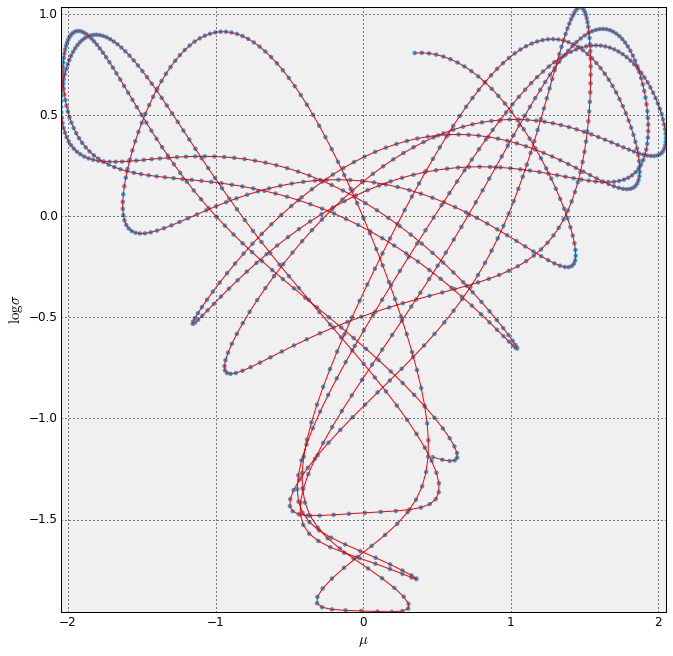

In [7]:
%%opts Overlay plot[figure_size=300, fontsize={'xlabel':15, 'ylabel':15, 'ticks':12}] 
%%opts Path style(color='red', linewidth=1, linestyle='-') 
hv.Points(xs, key_dimensions=['$\mu$', '$\log\sigma$']) * hv.Path([xs[:]]) 

Now lets see how the kinetic energy $E_k$ and potential energy $E_p$ varied over that simulated trajectory. The exact Hamiltonian dynamics would keep the total energy exactly constant so we would hope the discretised dynamic would approximately preserve this property which indeed does seem to be the case with the total Hamiltonian for the system $H = E_p + E_k$ remaining nearly constant over the trajectory. This corresponds to a low probability of rejecting any of the states along the trajectory if used as Metropolis-Hastings proposal.

:Overlay
   .Curve.E_p :Curve   [Number of updates]   (Energy)
   .Curve.E_k :Curve   [x]   (y)
   .Curve.H   :Curve   [x]   (y)
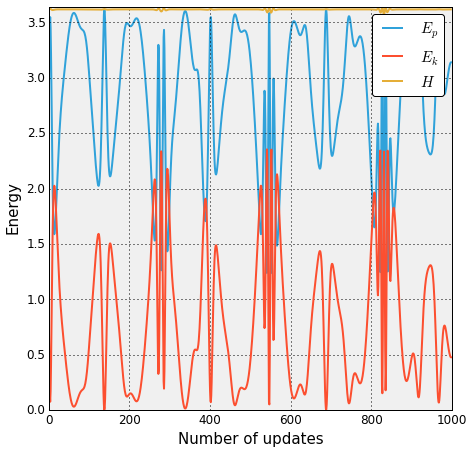

In [8]:
%%opts Overlay plot[figure_size=200, fontsize={'xlabel':15, 'ylabel':15, 'legend':15, 'ticks':12}]
potential_energies = -funnel_2d_log_density(xs.T)
kinetic_energies = 0.5 * (ps**2).sum(1)
hamiltonians = potential_energies + kinetic_energies
(hv.Curve(potential_energies, label='$E_p$', kdims=['Number of updates'], vdims=['Energy']) * 
 hv.Curve(kinetic_energies, label='$E_k$') *
 hv.Curve(hamiltonians, label='$H$'))

We can also verify that the discretised Hamiltonian dynamic is exactly reversible under momentum reversal

In [9]:
# simulate Hamiltonian dynamics from endpoint of previous trajectory reversing momentum
xs_bwd, ps_bwd = hmc_isotropic(
    funnel_2d_log_density, xs[-1], -ps[-1], n_sample, dt, n_leapfrog, phi, rs)
# verify parameters state trajectories are reversed versions of each other
assert np.allclose(xs, xs_bwd[::-1])
# verifty momentum state trajectories are negated and reversed versions of each other
assert np.allclose(ps, -ps_bwd[::-1])

Now lets do a sampling run with momentum refreshal to allow the energy level to vary. We will also increase the step size and number of leapfrog updates to more reasonable values for actual sampling (though these are unlikely to be optimal - one of the major drawbacks of HMC is the need to tune these parameters).

In [10]:
n_sample = 1000
dt = 0.2
n_leapfrog = 10
phi = 0.
xs, ps = hmc_isotropic(
    funnel_2d_log_density, x_init, None, n_sample, dt, n_leapfrog, phi, rs)

Plotting the resulting samples (and overlaying the trajectory of the first 50 updates) we can see that the sampler seems to be exploring the funnel distribution relatively well, with relatively large moves being made by the HMC updates. We can see however the sampler does not seem to fully explore the wider part of the funnel (higher $v$) as well - this is reflective of the locally varying geometry across this density with the appropriate scale (step size) varying significantly between the 'neck' and 'mouth' of the funnel. Standard HMC with a constant mass matrix does not have a mechanism for adjusting for such locally varying geometry however this is provided in the more complex variant Riemannian Manifold HMC.

:Overlay
   .Points.I :Points   [$\mu$,$\log\sigma$]
   .Path.I   :Path   [x,y]
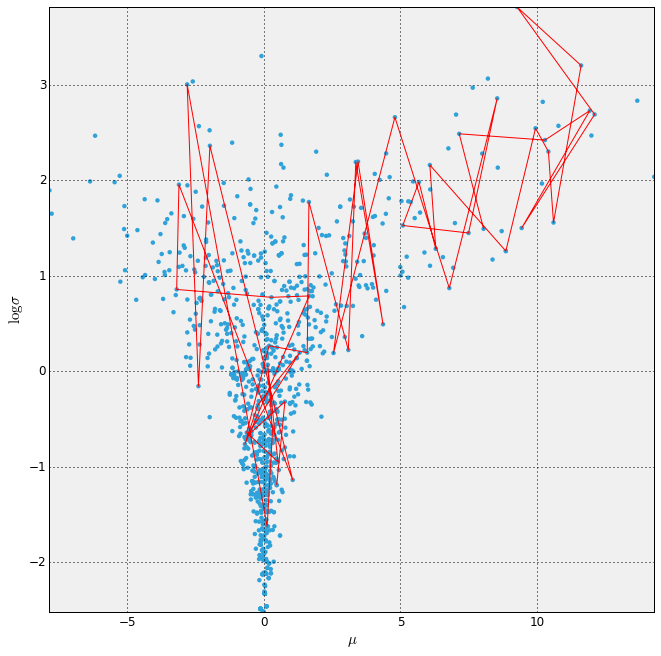

In [11]:
%%opts Overlay plot[figure_size=300, fontsize={'xlabel':15, 'ylabel':15, 'ticks':12}] 
%%opts Path style(color='red', linewidth=1, linestyle='-') 
hv.Points(xs, key_dimensions=['$\mu$', '$\log\sigma$']) * hv.Path([xs[:50]]) 

Plotting the autocorrelation of the $m$ and $v$ chains as curves (ignoring the fact that the lag is a discrete index for ease of visualisation...) we can see that the correlations decay relatively quickly

:Overlay
   .Curve.M :Curve   [Lag]   (Auto-correlation)
   .Curve.U :Curve   [x]   (y)
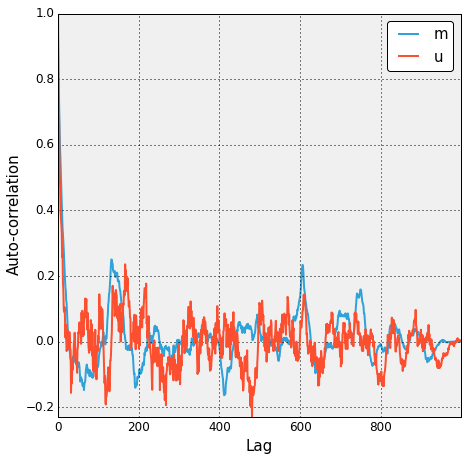

In [12]:
%%opts Overlay plot[figure_size=200, fontsize={'xlabel':15, 'ylabel':15, 'legend':15, 'ticks':12}] 
cs_m = np.correlate(xs[:, 0], xs[:, 0], mode='full')
cs_u = np.correlate(xs[:, 1], xs[:, 1], mode='full')
(hv.Curve(cs_m[n_sample:] / cs_m[n_sample], label='m', kdims=['Lag'], vdims=['Auto-correlation']) *
 hv.Curve(cs_u[n_sample:] / cs_u[n_sample], label='u'))